# Week5 Basic

- 해야할 과제

    1) https://spartacodingclub.kr/blog/all-in-challenge_winner 에서 수상작 요약하기

    2) chroma를 통해 query와 유사한 문서를 검색하여 llm에게 요약을 요청하기

- 더 해 볼 과제
    - 참조: https://huggingface.co/learn/cookbook/ko/advanced_ko_rag#%EC%9E%85%EB%A0%A5input

    1) query와 문서 정보 임베딩 시각화

    2) 로컬 모델로 임베딩과 문장 생성을 해보기.




## 1 [My Code] Data Preparation

### 1.1 [My Code] API Key Load

In [1]:
import os
import openai
from dotenv import load_dotenv

load_dotenv(dotenv_path="config.env")
openai.api_key = os.getenv("OPENAI_API_KEY")

### 1.2 [My Code] Model Load

- streaming = True

- callbacks = StreamingStdOutCallbackHandler

위의 두 가지 옵션을 주면, 문장이 최종 생성되는 과정을 시각화 해줍니다.

In [116]:
from langchain.callbacks import StreamingStdOutCallbackHandler
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model='gpt-4o-mini',
    temperature=0.7,
    max_tokens=1024,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()]
    )

### 1.3 [My Code] Data Load and preprocessing

- webbaseloader -> UnstructuredURLLoader 변경

- recursive splitter가 반복되는 데이터를 생산하는 것을 list -> set -> list 방식으로 중복 제거.

- 전체 문서 10가지 생성


    - 문서 수가 많지는 않지만 rag를 직접 구현해보는 것에 의의를 둔기로 합니다.

    - 전체 수상작은 6개 입니다. 추후에 몇 개나 요약되는지 확인해보도록 합니다.

In [119]:
from langchain_community.document_loaders import UnstructuredURLLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.schema import Document

# url을 unstructuredURLLoader를 사용해 불러옵니다.
# 해당 툴을 사용하면, 별다른 설정없이 url의 정보를 가져옵니다.
url = "https://spartacodingclub.kr/blog/all-in-challenge_winner"
loader = UnstructuredURLLoader(urls=[url])
docs = loader.load()

# 텍스트 분할기 설정
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=900,  # 각 청크의 최대 길이
    chunk_overlap=300  # 청크 간 겹침 부분 최소화
)

# 문서 분할
# recursive는 동일한 문서를 출력하는 경우가 있어, 아래처럼 list -> set -> list로 중복을 제거합니다.
split_docs = text_splitter.split_documents(docs)
splits = list(set([doc.page_content for doc in split_docs]))
splits = [
    Document(
        metadata={'idx': i},
        page_content=text_data
    )
        for i, text_data in enumerate(splits)
]

for i, doc in enumerate(splits):
    print(f"{i+1}번째")
    print(len(doc.page_content))
    print(doc.page_content)
    print("###\n")

1번째
863
앱 내의 학점 계산기를 사용하면 성적이 그래프로 시각화되어 변화를 쉽게 파악할 수 있고, 앞으로의 성적 목표를 세우는 데에도 큰 도움이 됩니다. 예상 학점 기능을 통해 과목별 예상 등수와 학점을 미리 계산해 보며 학습 계획도 조정할 수 있어요. <학교생활 매니저>앱을 사용하면 체계적으로 대학 생활을 관리하고, 남은 학업과 일정을 효율적으로 관리할 수 있습니다.

사용한 기술 스택

FE(프론트엔드): Flutter

BE(백엔드): Firebase

🏅 입선

[BLOTIE] 교내 외국인X내국인 매칭 및 교류 플랫폼

서비스 제작자: 블로티(이은주, 한명수, 황준영)

💡F는 T대학에 교환학생으로 온 외국인입니다. K팝 문화가 좋아 한국에 왔지만, 말도 잘 통하지 않고 문화 차이도 있어서 한국 캠퍼스 생활이 쉽지만은 않은데요. 한국어로 수업을 듣고 한국 친구도 사귀고 싶지만 한국 대학의 학사 일정과 과제 등 여러 시스템이 달라서 적응하기 어려웠습니다. 한국어가 서툴다보니 수업에서 제공되는 다양한 정보를 이해하기 어려웠고, 중요한 공지사항을 놓치기도 했습니다. 한국인 친구를 먼저 사귀는 것이 급선무라고 생각했죠.

<BLOTIE>는 외국인 학생이 가진 이런 문제를 해결하고, 보다 친밀하고 자유로운 글로벌 캠퍼스 문화를 조성하기 위해 만들어진 플랫폼입니다. ‘1:1 매칭 기능’으로 교내 외국인 학생과 한국인 학생을 쉽게 연결할 수 있어요. 서로의 문화와 언어를 자연스럽게 배우고 교류할 수 있습니다. 관심사, 언어 능력, 성격 등을 기반으로 이뤄지기 때문에 일회성 매칭에 대한 걱정도 줄어들어요. 매칭된 학생들은 플랫폼 내에서 ‘실시간 채팅과 피드 기능’으로 자유롭게 소통할 수 있고, 다양한 주제로 만남을 이어갈 수 있습니다.
###

2번째
814
사용한 기술 스택

FE(프론트엔드): Flutter, Socket.IO, Expo CLI, Axios, TanStack Query

BE(백엔드): Spring Boot, Spring Security, J

## 2 [My Code] Text Retrieval

### 2.1 [My Code] Chroma Database 

- 코사인 유사도 방식으로 전체 문서에서 40%만 추출합니다.

In [128]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

# OpenAI Embeddings 초기화
# https://platform.openai.com/docs/guides/embeddings
embeddings = OpenAIEmbeddings(
    api_key=openai.api_key,
    model="text-embedding-3-small"
)

# Chroma 벡터 저장소 생성 및 로컬 저장 경로 지정
vectorstore = Chroma.from_documents(
    documents=splits,
    embedding=embeddings,
    collection_name="my_db"
)

# 전체 문서의 40%를 출력합니다.
chroma_retriever = vectorstore.as_retriever(
    search_type='similarity',
    search_kwargs={'k': int(len(splits) * 0.4)}
)

user_msg = "ALL-in 코딩 공모전 수상작들을 요약해줘."
retrieved_docs = chroma_retriever.invoke(user_msg)
retrieved_docs

[Document(id='9168e6ca-eef1-46ff-888d-f5ef04af9f45', metadata={'idx': 4}, page_content="로그인\n\n로그아웃\n\n스파르타 소식\n\n'AII-in 코딩 공모전’ 수상작을 소개합니다\n\n조회수 454·6분 분량\n\n2024. 9. 3.\n\n코딩은 더 이상 개발자만의 영역이 아닙니다. 누구나 아이디어만 있다면 창의적인 서비스를 만들어 세상을 바꿀 수 있습니다. 스파르타코딩클럽에서는 이러한 가능성을 믿고, 누구나 코딩을 통해 자신의 아이디어를 실현하고 실제 문제를 해결하는 경험을 쌓을 수 있도록 다양한 프로그램을 마련하고 있습니다.\n\n<All-in> 코딩 공모전은 대학생들이 캠퍼스에서 겪은 불편함과 문제를 자신만의 아이디어로 해결해보는 대회였는데요. 이번 공모전에서 다양한 혁신적인 아이디어와 열정으로 가득한 수많은 프로젝트가 탄생했습니다. 그중 뛰어난 성과를 낸 수상작 6개를 소개합니다.\n\n🏆 대상\n\n[Lexi Note] 언어공부 필기 웹 서비스\n\n서비스 제작자: 다나와(김다애, 박나경)\n\n💡W는 어문학을 전공하는 대학생입니다. 매일 새로운 단어와 문장 구조를 공부하고 있지만, 효율적으로 학습하는 것이 쉽지 않았습니다. 단어의 의미를 찾기 위해 사전을 뒤적이고, 긴 문장을 이해하려고 번역기를 사용하다 보면, 필기 노트는 어느새 뒷전으로 밀려났거든요. 사전, 번역기, 원서, 필기노트를 왔다 갔다 하다 보면 시간이 다 지나가 버리곤 했죠."),
 Document(id='7c1002a3-003a-4631-ad0b-bcf244894523', metadata={'idx': 3}, page_content='💡<All-in> 코딩 공모전에서 만든 다양한 서비스를 만나보고 싶다면?\n\n다양한 서비스와 기발한 아이디어가 모인 곳에 초대합니다. 참가자들의 문제 해결방법이 궁금하시다면 지금 바로 ‘All-in 공모전’에서 만나보세요!\n\n👉🏻 공모전 결과물 보러가기\n\n누구나 큰일 낼 

### 2.2 [My Code] 임베딩 정보

- openai 모델 중 text-embedding-3-small로 임베딩을 하였습니다.

- 차원 수는 1536입니다.

In [129]:
# https://stackoverflow.com/questions/76482987/chroma-database-embeddings-none-when-using-get
# embedding 정보를 보기 위해선 아래처럼 include 에 인자로 embeddings를 넣어줘야 합니다.
# 벡터 개수 확인
vector_count = vectorstore._collection.count()

# query의 임베딩 결과를 표시합니다
query_vector = embeddings.embed_query(user_msg)

print("사용하는 임베딩 모델:", embeddings.model)
print("(문서 수, 차원) = ", vectorstore.get(include=['embeddings'])['embeddings'].shape)
print("임베딩 표현 : ", vectorstore.get(include=['embeddings'])['embeddings'][0])
print(f"쿼리 임베딩 결과: {len(query_vector)} 차원")

사용하는 임베딩 모델: text-embedding-3-small
(문서 수, 차원) =  (10, 1536)
임베딩 표현 :  [-0.01972526  0.01340087 -0.02550267 ... -0.00026832  0.00123639
  0.00204546]
쿼리 임베딩 결과: 1536 차원


### 2.3 [My Code] 벡터 임베딩 시각화

- 아래는 문서와 query를 임베딩한 것을 umap을 통해 시각화해보는 과정입니다.

- umap은 비선형적 차원 축소 방법입니다.

- umap을 기반으로 query 근방의 doc과 retrieve 된 docs가 얼마나 일치하는지 확인해볼 것입니다.

- [Feedback] 코사인 유사도 기반으로 추출된 문서는 4,3,6,7번인데, 아래 시각화 정보에 따르면 5번도 포함되어야 하는 것 같습니다. umap이 차원축소하는 과정에서 코사인 유사도를 대표하지 못한 결과인 것 같은데 이에 대한 자세한 설명을 들을 수 있으면 좋겠습니다. 

/home/paradeigma/workspace/python/sparta_coding/.env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/paradeigma/workspace/python/sparta_coding/.env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/paradeigma/workspace/python/sparta_coding/.env/lib/python3.9/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


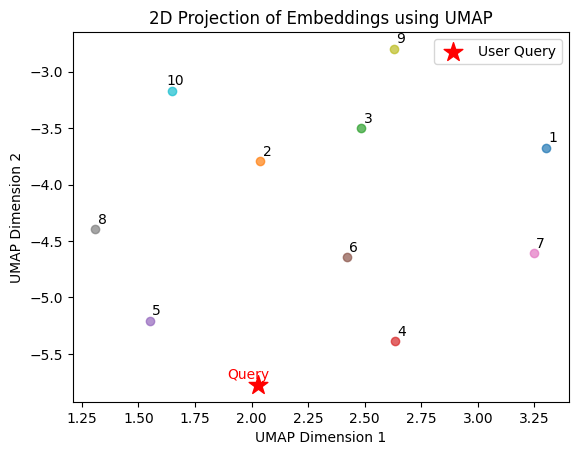

In [114]:
# 벡터 스토어와 query의 임베딩 결과를 시각화할 예정입니다. 
# query에서 근접한 점들과 retrieval을 통해 추출된 문서가 어느정도 일치하는지 확인해보겠습니다. 
import umap
import numpy as np
import matplotlib.pyplot as plt

# 모든 문서의 벡터 가져오기
doc_embeddings = vectorstore._collection.get(include=['embeddings'])["embeddings"]
embeddings_2d = np.concatenate([doc_embeddings, np.array(query_vector).reshape(1,-1)], axis=0)

# UMAP으로 2D 변환
# PCA는 선형적 방법으로 차원을 축소한다면, umap은 비선형적 방법으로 차원을 축소합니다. 
reducer = umap.UMAP(n_components=2, random_state=42)
documents_projected = reducer.fit_transform(embeddings_2d)

# 문서별로 점과 텍스트 추가
for i, doc in enumerate(splits):
    x, y = documents_projected[i]
    plt.scatter(x, y, alpha=0.7)
    plt.text(x+0.05, y+0.05, f"{i+1}", fontsize=10, ha='right') 

# 사용자 쿼리 표시
query_x, query_y = documents_projected[-1]
plt.scatter(query_x, query_y, color="red", label="User Query", marker="*", s=200)
plt.text(query_x+0.05, query_y+0.05, "Query", fontsize=10, color="red", ha='right')  

# 그래프 설정
plt.title("2D Projection of Embeddings using UMAP")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(loc="best")
plt.show()


## 3 [My Code] Conclusion

- 6가지 입선작 중에서 2가지만 나온 것으로 확인이 됩니다.

- 전체 문서량 자체가 작은데, 거기에서 일부를 추출하는 과정에서 정보가 많이 탈락한 것으로 결론을 내릴 수 있습니다. 

- 최근 만능 rag론이 대두되고 있는데, 문서를 어떻게 전처리 할 것인지, 그리고 어떻게 잘 검색할 것인지를 다듬지 않고선 무딘 칼과 같다고 할 수 있습니다. 

In [130]:
from langchain import hub

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

prompt = hub.pull("rlm/rag-prompt")
user_prompt = prompt.invoke({"context": format_docs(retrieved_docs), "question": user_msg})
response = llm.invoke(user_prompt)

/home/paradeigma/workspace/python/sparta_coding/.env/lib/python3.9/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


'ALL-in 코딩 공모전'에서는 대학생들이 캠퍼스에서 겪는 문제를 해결하기 위한 다양한 프로젝트가 출품되었습니다. 수상작 중 하나인 'Lexi Note'는 언어 학습을 효율적으로 도와주는 웹 서비스로, 단어 검색과 필기를 동시에 수행할 수 있습니다. 또한 '우리집 히어로즈'는 벌레 퇴치 서비스를 매칭하는 플랫폼으로, 여러 혁신적인 아이디어들이 주목받았습니다.

In [132]:
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
# from langchain.vectorstores import FAISS
# from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model_name = "snunlp/KR-SBERT-V40K-klueNLI-augSTS"
embedding_model = HuggingFaceEmbeddings(
    model_name=embedding_model_name,
    encode_kwargs={"normalize_embeddings": True},
)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/336k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/967k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [133]:
# url을 unstructuredURLLoader를 사용해 불러옵니다.
# 해당 툴을 사용하면, 별다른 설정없이 url의 정보를 가져옵니다.
url = "https://spartacodingclub.kr/blog/all-in-challenge_winner"
loader = UnstructuredURLLoader(urls=[url])
docs = loader.load()

# 텍스트 분할기 설정
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=900,  # 각 청크의 최대 길이
    chunk_overlap=300  # 청크 간 겹침 부분 최소화
)

# 문서 분할
# recursive는 동일한 문서를 출력하는 경우가 있어, 아래처럼 list -> set -> list로 중복을 제거합니다.
split_docs = text_splitter.split_documents(docs)
splits = list(set([doc.page_content for doc in split_docs]))
splits = [
    Document(
        metadata={'idx': i},
        page_content=text_data
    )
        for i, text_data in enumerate(splits)
]


In [137]:
# Chroma 벡터 저장소 생성 및 로컬 저장 경로 지정
vectorstore = Chroma.from_documents(
    documents=splits,
    embedding=embedding_model,
    collection_name="my_db_local_embeddings"
)

# 전체 문서의 40%를 출력합니다.
chroma_retriever = vectorstore.as_retriever(
    search_type='similarity',
    search_kwargs={'k': int(len(splits) * 0.4)}
)

user_msg = "ALL-in 코딩 공모전 수상작들을 요약해줘."
retrieved_docs = chroma_retriever.invoke(user_msg)
retrieved_docs

[Document(id='7e0ab2ff-f7ef-4b8f-9bd7-77a2ae08057c', metadata={'idx': 4}, page_content="로그인\n\n로그아웃\n\n스파르타 소식\n\n'AII-in 코딩 공모전’ 수상작을 소개합니다\n\n조회수 454·6분 분량\n\n2024. 9. 3.\n\n코딩은 더 이상 개발자만의 영역이 아닙니다. 누구나 아이디어만 있다면 창의적인 서비스를 만들어 세상을 바꿀 수 있습니다. 스파르타코딩클럽에서는 이러한 가능성을 믿고, 누구나 코딩을 통해 자신의 아이디어를 실현하고 실제 문제를 해결하는 경험을 쌓을 수 있도록 다양한 프로그램을 마련하고 있습니다.\n\n<All-in> 코딩 공모전은 대학생들이 캠퍼스에서 겪은 불편함과 문제를 자신만의 아이디어로 해결해보는 대회였는데요. 이번 공모전에서 다양한 혁신적인 아이디어와 열정으로 가득한 수많은 프로젝트가 탄생했습니다. 그중 뛰어난 성과를 낸 수상작 6개를 소개합니다.\n\n🏆 대상\n\n[Lexi Note] 언어공부 필기 웹 서비스\n\n서비스 제작자: 다나와(김다애, 박나경)\n\n💡W는 어문학을 전공하는 대학생입니다. 매일 새로운 단어와 문장 구조를 공부하고 있지만, 효율적으로 학습하는 것이 쉽지 않았습니다. 단어의 의미를 찾기 위해 사전을 뒤적이고, 긴 문장을 이해하려고 번역기를 사용하다 보면, 필기 노트는 어느새 뒷전으로 밀려났거든요. 사전, 번역기, 원서, 필기노트를 왔다 갔다 하다 보면 시간이 다 지나가 버리곤 했죠."),
 Document(id='6e469c38-54f8-499e-8aba-ff0a3afb9594', metadata={'idx': 3}, page_content='💡<All-in> 코딩 공모전에서 만든 다양한 서비스를 만나보고 싶다면?\n\n다양한 서비스와 기발한 아이디어가 모인 곳에 초대합니다. 참가자들의 문제 해결방법이 궁금하시다면 지금 바로 ‘All-in 공모전’에서 만나보세요!\n\n👉🏻 공모전 결과물 보러가기\n\n누구나 큰일 낼 

In [ ]:
from langchain.llms import HuggingFacePipeline

In [ ]:
from langchain import hub

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

prompt = hub.pull("rlm/rag-prompt")
user_prompt = prompt.invoke({"context": format_docs(retrieved_docs), "question": user_msg})
response = llm.invoke(user_prompt)